<a href="https://colab.research.google.com/github/AlexeyK12/Data_scientist-Sberuniversity/blob/main/%D0%91%D0%B5%D0%B3%D0%B3%D0%B8%D0%BD%D0%B3_%D0%B3%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B9_%D0%B1%D1%83%D1%81%D1%82%D0%B8%D0%BD%D0%B3_XGBoost_CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Беггинг, градиентный бустинг, XGBoost, LightGBM, Catboost

# Теоретическая часть

## Бэггинг

Обучающие выборки генерируются с помощью **бутстрепа**.  
Рассмотрим выборку $X$, состоящую из $N$ объектов. Пусть имеется $M$ базовых моделей. Тогда алгоритм выглядит следующим образом:
1. Из всего множества объектов равновероятно выбираются $N$ объектов с возвращением (после выбора каждого из объектов мы будем возвращать его в множество для выбора, из-за чего некоторые объекты могут повторяться в выбранном множестве)
2. Повторяем п. 1 $M$ раз. Таким образом, получаем новые подвыборки $X_1, ..., X_M$




### Классификация

Бэггинг для задач классификации выглядит следующим образом:
1. С помощью бутстрепа генерируем $M$ выборок для каждого базового классификатора, каждая из которых содержит $N$ объектов
2. Независимо обучаем каждый базовый классификатор (каждый алгоритм, определенный на своем подпространстве)
3. Классифицируем основную выборку на каждом из подпространств (также независимо)
4. Принимаем окончательное решение о принадлежности объекта одному из классов. Наиболее распространенными методами принятия таких решений являются:
  - **консенсус** — все базовые классификаторы присвоили объекту одну и ту же метку $\implies$ относим объект к выбранному классу (консенсус достижим очень редко, поэтому это не самый популярный метод)
  - **простое большинство** — наиболее часто применяемый метод. Объекту присваивается метка того класса, который определило для него большинство базовых классификаторов
  - **взвешивание классификаторов** — решение принимается с учетом «важности» каждого классификатора (например, для экспертов одна из групп параметров важна в большей степени или имеется четное число базовых классификаторов, мнения которых разделились поровну)

### Регрессия

Рассмотрим задачу регрессии с базовыми алгоритмами $b_1, ..., b_m$. Пусть существует истинная функция ответа для всех объектов $y(x)$ $(y = 1,...,n)$, а также задано распределение $p(x)$ на объектах. В этом случае мы можем записать ошибку каждой функции регрессии:

$$\epsilon_i(x) = b_i(x) − y(x).$$

При этом мат. ожидание среднеквадратичной ошибки:

$$E_x(b_i(x) − y(x))^2 = E_x \epsilon_i^2(x).$$

Тогда средняя ошибка построенных функций регрессии имеет вид:

$$E_1 = \frac{1}{n} E_x \sum_{i = 1}^{n} \epsilon_i^2(x).$$

Пусть ошибки несмещены и некоррелированы, т. е.:

$$E_x \epsilon_i (x) = 0$$ $$E_x \epsilon_i (x) \epsilon_j (x) = 0, i \neq j.$$

Новая модель, усредняющая ответы уже построенных, будет иметь вид:

$$a(x) = \frac{1}{n} \sum_{i = 1}^{n} b_i(x).$$

Ее среднеквадратичная ошибка:

$$E_n = E_x(\frac{1}{n} \sum_{i = 1}^{n} (b_i(x) − y(x))^2) = E_x (\frac{1}{n} \sum_{i = 1}^{n} \epsilon_i)^2 = \frac{1}{n^2} E_x(\sum_{i = 1}^{n} \epsilon_i^2(x) + \sum_{i \neq j} \epsilon_i(x) \epsilon_j(x)) = \frac{1}{n} E_1,$$

т. е. усреднение ответов позволило уменьшить средний квадрат ошибки в $n$ раз.

Наиболее ярким представителем бэггинга является **случайный лес**, который мы будем сравнивать в наших экспериментах с различными реализациями градиентного бустинга.

## Градиентный бустинг

Бустинг — метод ансамблирования алгоритмов (принадлежащих одному семейству), который состоит в том, что каждый последующий добавляемый в ансамбль  алгоритм обучается так, чтобы уменьшать ошибку уже построенной части ансамбля, т. е.

$$\hat{a}(X) = \sum_{i = 1}^{N} \rho_i a_i(X),$$
где $X$ — входные данные, $\hat{a}(X)$ — ансамбль моделей, $a_i(X)$ — базовые модели, $\rho_i$ — коэффициенты, с которыми учитываются базовые модели.  

Градиентный бустинг — один из основных алгоритмов бустинг-моделей. Его алгоритм выглядит следующим образом:
1. Выбирается дифференцируемая функция потерь (подходящая для конкретной задачи, но обычно и для классификации, и для регрессии выбирается среднеквадратичная ошибка (MSE))
2. Выбирается простая начальная модель $a_0$. Если решается задача регрессии, то $a_0$ — среднее значение целевой переменной, если классификации —  выборочные вероятности (доля каждого класса) в случае классификации
3. Пусть уже построены $(t - 1)$ алгоритмов. Вычисляем значение антиградиента функции потерь (производные берутся по ответу построенного ансамбля на обучающей выборке как по независимой переменной) в точке $(X, \hat{a}(X))$
4. Проводится обучение модели $a_t$. В качестве целевой переменной используются значения антиградиента, полученные на предыдущем шаге
5. При этом подбирается коэффициент $\rho_t$ таким образом, чтобы минимизировать значение функции потерь для ансамбля с новым алгоритмом
6. Шаги 2–5 повторяются до тех пор, пока это необходимо (возможные критерии остановки: достигнуто желаемое количество алгоритмов, достигнуто желаемое качество, ошибка или модуль градиента достаточно мал и т. д.)

Формулы выглядят следующим образом:

$$\hat{a}(X) = \sum_{i = 0}^{t - 1} \hat{a_i}(X),$$
где $\hat{a_i}(X)$ — уже построенные $(t - 1)$ базовые модели, $\hat{a}(X)$ — имеющийся ансамбль $t - 1$ базовых моделей. Тогда антиградиенты будут иметь вид:

$$r_{it} = -\left[\frac{\delta L(y_i, a(\mathbf{x_i}))}{\delta a(\mathbf{x_i})}\right]_{a(X) = \hat{a}(X)},$$
где $L(\cdot, \cdot)$ — функция потерь, $i \in [1, n]$.  



### Реализации градиентного бустинга

Существует много готовых реализаций алгоритма градиентного бустинга, например он есть в рассматриваемой нами и активно использовавшейся в предыдущих лонгридах и семинарах библиотеке `sklearn`. Однако на практике используются следующие реализации:
* **XGBoost** (март 2014)
* **LightGBM** (январь 2017)
* **CatBoost** (апрель 2017)

#### Рост листьев
* **XGboost** проводит разделение до заданного гиперпараметра `max_depth`, затем начинает обрезать дерево в обратном направлении и удаляет части, за пределами которых нет положительного выигрыша. Такой подход используется, поскольку иногда за расщеплением без уменьшения потерь может следовать расщепление с уменьшением потерь. XGBoost также может выполнять рост дерева по листьям (как **LightGBM**)

* **LightGBM** использует рост дерева по листьям (по принципу «лучший — первый»). Он выбирает для роста тот лист, который минимизирует потери, что позволяет вырастить несбалансированное дерево. Поскольку дерево растет не по уровням, а по листьям, при использовании небольшого количества данных может произойти полный перебор всех элементов, поэтому важно контролировать глубину дерева

* **Catboost** строит сбалансированное дерево. На каждом уровне такого дерева выбирается пара «признак — разделение», которая приносит наименьшие потери (согласно функции потерь) и используется для всех узлов уровня. Можно выбрать другие правила построения дерева с помощью гиперпараметра `grow-policy`




Сравнение способа формирования деревьев при различных методах градиентного бустинга:

![image.png](https://sun9-66.userapi.com/impg/LmGF5BxTfgicAhFPx_BctuLCqLDgW9NQMNZHVg/qf0V59WwTa0.jpg?size=875x329&quality=96&sign=10659374cced9cc7d8ee4d78bb80757b&type=album)

#### Обработка пропущенных значений
* **XGboost** определяет пропущенные значения в ту сторону, которая уменьшает потери в каждом разбиении

* **LightGBM** действует аналогично **XGBoost**

* **Catboost** имеет два режима обработки отсутствующих значений:
    - **Min** — отсутствующим значениям присваивается такое значение, которое будет меньше всех существующих значений в выборке
    - **Max** — отсутствующим значениям присваивается такое значение, которое будет больше всех существующих значений в выборке
    
  Таким образом, гарантируется, что при выборе разбиения будет учитываться разбиение, которое отделяет отсутствующие значения от всех остальных значений.

#### Метод важности признаков
* В **XGboost** имеются следующие методы:  
    * **Gain** — представляет собой улучшение точности (или общего выигрыша), приносимое признаком ветвям, на которых он находится
    * **Frequency**/**Weight** — вычисляет относительное количество раз, когда определенный признак встречается во всех расщеплениях деревьев модели. Может быть необъективным для категориальных признаков с большим количеством категорий
    * **Coverage** — относительное количество наблюдений, связанных с признаком. Для каждого признака мы подсчитываем количество наблюдений, используемых для выбора узла листа
* **LightGBM** также содержит метод **Gain** и метод **Split**, аналогичный **Frequency**/**Weight** из **XGBoost**.

* **Catboost** содержит следующие методы:  
    * **PredictionValuesChange** — для каждого признака **PredictionValuesChange** показывает, насколько в среднем изменяется предсказание при изменении значения признака. Признак будет иметь большую важность, если изменение значения признака вызывает большое изменение в прогнозируемом значении
    * **PredictionValuesChange** — метод расчета важности признака по умолчанию для неранжированных метрик  
    * **LossFunctionChange** — может использоваться для любой модели, но особенно полезен для моделей ранжирования. Для каждого признака представляет собой разницу между значением потерь модели с этим признаком и без него. Поскольку переобучение модели без одного из признаков требует больших вычислительных затрат, эта модель строится приблизительно, используя исходную модель с этим признаком, удаленным из всех деревьев в ансамбле

#### Обработка категориальных признаков

* **XGBoost** не имеет встроенного метода для категориальных признаков. Кодирование категориальных признаков должно выполняться в процессе предобработки данных

* **LightGBM** разделяет категориальные признаки, разбивая их категории на 2 подмножества. Основная идея заключается в том, чтобы сортировать категории в соответствии с целью обучения при каждом разбиении  

* **Catboost** использует комбинацию одноточечного кодирования и расширенного среднего кодирования. Для признаков с малым количеством категорий используется одноточечное кодирование. Максимальное количество категорий для одноточечного кодирования можно контролировать с помощью параметра `one_hot_max_size`. Для остальных категориальных столбцов **CatBoost** использует эффективный метод кодирования, который похож на среднее кодирование, но с дополнительным механизмом, направленным на снижение переподгонки. Использование категориального кодирования CatBoost имеет обратную сторону — более медленная модель





# Практическая часть

## Классификация

Будем использовать датасет [отсюда](https://www.kaggle.com/datasets/uciml/mushroom-classification).

### Скачивание данных

In [ ]:
from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')
files.upload()

Mounted at /content/gdrive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rogulina","key":"9cec35de6d210241a0575962c48f98fa"}'}

In [ ]:
!ls -lha kaggle.json

!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d whenamancodes/predict-diabities
!unzip predict-diabities.zip

-rw-r--r-- 1 root root 64 Nov 23 13:57 kaggle.json
  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 7.89MB/s]
Archive:  predict-diabities.zip
  inflating: diabetes.csv            


In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Импорт всех необходимых библиотек

In [ ]:
# Чтобы установить библиотеку `catboost`, раскомментируйте строку ниже

# !pip install catboost

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
)
from sklearn.metrics import (
    f1_score, average_precision_score, # метрики для задачи классификации
    mean_squared_error, mean_absolute_error, r2_score, # метрики для задачи регрессии
)
from sklearn.preprocessing import OrdinalEncoder

# Модели, которые будем рассматривать
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
)
from xgboost import (
    XGBClassifier,
    XGBRegressor,
)
from lightgbm import (
    LGBMClassifier,
    LGBMRegressor,
)
from catboost import (
    CatBoostClassifier,
    CatBoostRegressor,
)

In [ ]:
# Установим размеры шрифтов для графиков
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', size=16)          # размеры текста по умолчанию
plt.rc('axes', titlesize=20)     # размер шрифта заголовка осей
plt.rc('axes', labelsize=18)     # размер шрифта названия осей
plt.rc('xtick', labelsize=18)    # размер шрифта меток по оси x
plt.rc('ytick', labelsize=18)    # размер шрифта меток по оси y
plt.rc('legend', fontsize=16)    # размер шрифта легенды
plt.rc('figure', titlesize=20)   # размер шрифта заголовка всего графика

### Чтение, анализ и предобработка данных

In [ ]:
df = pd.read_csv("diabetes.csv")
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
target = df["Outcome"]

df = df.drop("Outcome", axis=1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


Кажется, что все колонки численные. Проверим это:

In [ ]:
numerical_cols = df.select_dtypes(exclude=["object"]).columns.tolist()
len(numerical_cols) == df.shape[1]

True

### Деление выборки на обучающую и тестовую

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df,
    target,
    test_size=0.33,
    random_state=42,
    stratify=target, # поделим выборку таким образом, чтобы и в обучающей, и в тестовой выборке было такое же соотношение классов, как и в исходных данных
)

In [ ]:
# Посмотрим на баланс классов

val_count_init = pd.Series(target).value_counts().to_dict()
val_count_train = y_train.value_counts().to_dict()
val_count_test = y_test.value_counts().to_dict()

get_relation = lambda x: round(x[1] / x[0], 2)

print(
    """
    Соотношение классов в исходной выборке:  {}\t(класс 1 / класс 0 = {})
    Соотношение классов в обучающей выборке: {}\t(класс 1 / класс 0 = {})
    Соотношение классов в тестовой выборке:  {}\t(класс 1 / класс 0 = {})
    """.format(
        val_count_init, get_relation(val_count_init),
        val_count_train, get_relation(val_count_train),
        val_count_test, get_relation(val_count_test),
    )
)


    Соотношение классов в исходной выборке:  {0: 500, 1: 268}	(класс 1 / класс 0 = 0.54)
    Соотношение классов в обучающей выборке: {0: 335, 1: 179}	(класс 1 / класс 0 = 0.53)
    Соотношение классов в тестовой выборке:  {0: 165, 1: 89}	(класс 1 / класс 0 = 0.54)
    


Будем проводить подбор гиперпараметров для каждой модели с помощью функции из ячейки ниже:

In [ ]:
def gridsearch(X_train, y_train, model, params, scoring, cv):
  """Перебор всевозможных гиперпараметров.

  :param X_train: объекты обучающей выборки
  :param y_train: значения целевой переменной обучающей выборки
  :param model: модель, для которой производится подбор гиперпараметров
  :param params: словарь с названиями гиперпараметрамов и всеми наборами значений
  :param scoring: функция, которая будет минимизироваться в ходе кросс-валидации (можно передать список метрик)
  :param cv: количество частей, на которые будет поделена выборка

  :return: наилучшие гиперпараметры
  """
  searcher = GridSearchCV(
      estimator=model,
      param_grid=params,
      scoring=scoring,
      cv=cv,
      verbose=0, # чтобы выводилось что-то в процессе подбора параметров, необходимо выставить какое-то значение > 0
  )
  searcher.fit(X_train, y_train)
  best_params = searcher.best_params_

  # print("Best hyperparameters:", best_params)
  return best_params

Для обучения и тестирования модели будем использовать функцию ниже:

In [ ]:
def model_train_test(X_train, y_train, X_test, y_test, model, model_type):
    """Обучение и тестирование модели на обучающей и тестовой выборке соответственно.

    :param X_train: объекты обучающей выборки
    :param y_train: значения целевой переменной обучающей выборки
    :param X_test: объекты тестовой выборки
    :param y_test: значения целевой переменной тестовой выборки
    :param model: модель, которая обучается и тестируется
    :param model_type: тип модели: 'classification' или 'regression'
    :return: предсказания и метрики
    """
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    if model_type == "regression":
        mse = mean_squared_error(y_test, pred)
        mae = mean_absolute_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        print("MSE = {}; MAE = {}; R2 = {}".format(round(mse, 3), round(mae, 3),round(r2, 3)))
        return pred, (mse, mae, r2)
    elif model_type == "classification":
        f1 = f1_score(y_test, pred)
        proba = model.predict_proba(X_test)[:, 1]
        pr_auc = average_precision_score(y_test, proba)
        print("F1 = {}; PR AUC = {}".format(round(f1, 3), round(pr_auc, 3)))
        return (pred, proba), (f1, pr_auc)
    else:
        raise Exception("Тип модели model_type должен быть 'classification' или 'regression'.")

In [ ]:
def find_and_train_test_best_params(
    X_train, y_train,
    params, scoring, cv,
    X_test, y_test,
    model, model_type
):
    """Подбор гиперпараметров и обучение и тестирование модели с наилучшими гиперпараметрами.

    :param X_train: обучающая выборка (без целевой переменной)
    :param y_train: целевая переменная обучающей выборки
    :param params: параметры, которые будут перебираться
    :param scoring: метрика, по которой будут подбираться гиперпараметры (можно передать список метрик)
    :param cv: кол-во секций, на которое будет делиться выборка для перекрестной проверки
    :param X_test: тестовая выборка (без целевой переменной)
    :param y_test: целевая переменная тестовой выборки
    :param model: модель
    :param model_type: тип модели: 'classification' или 'regression'
    :return: наилучшие подобранные гиперпараметры, предсказания и метрики
    """
    print(str(model))
    best_params = gridsearch(X_train, y_train, model(), params, scoring, cv)
    print("Best hyperparameters:", best_params)
    preds, metrics = model_train_test(X_train, y_train, X_test, y_test, model(**best_params), model_type)
    return best_params, preds, metrics

### Сравнение моделей

Зафиксируем параметры, которые не будут меняться.

In [ ]:
CONFIG_DATA = {
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
}

In [ ]:
ans_cl = dict()
print("Результаты моделей с гиперпараметрами по умолчанию\n")
for model_name, model in zip(
    ["RandomForest", "XGBoost", "LightGBM", "CatBoost"],
    [RandomForestClassifier(), XGBClassifier(), LGBMClassifier(), CatBoostClassifier(verbose=0)]
):
    print(model_name)
    preds, metrics = model_train_test(model=model, model_type="classification", **CONFIG_DATA)
    ans_cl[model_name] = (preds, metrics)
    print("-"*100)

Результаты моделей с гиперпараметрами по умолчанию

RandomForest
F1 = 0.627; PR AUC = 0.712
----------------------------------------------------------------------------------------------------
XGBoost
F1 = 0.617; PR AUC = 0.697
----------------------------------------------------------------------------------------------------
LightGBM
F1 = 0.602; PR AUC = 0.659
----------------------------------------------------------------------------------------------------
CatBoost
F1 = 0.609; PR AUC = 0.702
----------------------------------------------------------------------------------------------------


In [ ]:
ans_cl_df = pd.DataFrame(ans_cl).T
ans_cl_df["F1"] = ans_cl_df[1].apply(lambda x: x[0])
ans_cl_df["PR AUC"] = ans_cl_df[1].apply(lambda x: x[1])
ans_cl_df = ans_cl_df.drop([0, 1], axis=1)

# Отсортируем по убыванию получившуюся таблицу
ans_cl_df.sort_values(["F1", "PR AUC"], ascending=False)

,F1,PR AUC
RandomForest,0.626506,0.712010
XGBoost,0.617284,0.697381
CatBoost,0.608696,0.702441
LightGBM,0.602410,0.659066


Наиболее высокие результаты показал случайный лес (с точки зрения обеих метрик), хотя результаты не очень высокие для всех моделей. Проведем подбор гиперпараметров и сравним новые результаты. Для начала зафиксируем параметры функций, которые не будут меняться:

In [ ]:
CONFIG_CV = {
    "cv": 5,
}

In [ ]:
CONFIG_CL = {
    "scoring": "f1", # подбирать гиперпараметры будем по F1-мере
    "model_type": "classification",
}

In [ ]:
%%time
# чтобы посмотреть, сколько по времени выполняется ячейка

rf_params = {
    "n_estimators": [50, 100, 200, 1000], # default = 100
    "max_depth": [None] + [1, 3, 6, 9], # default = None
}

best_params_rf, preds_rf, metrics_rf = find_and_train_test_best_params(
    model=RandomForestClassifier,
    params=rf_params,
    **CONFIG_DATA,
    **CONFIG_CV,
    **CONFIG_CL,
)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Best hyperparameters: {'max_depth': 9, 'n_estimators': 200}
F1 = 0.612; PR AUC = 0.711
CPU times: user 1min 20s, sys: 560 ms, total: 1min 20s
Wall time: 1min 35s


In [ ]:
%%time

xgb_params = {
    "n_estimators": [50, 100, 200, 1000], # default = 100
    "max_depth": [1, 3, 6, 9], # default = 3
}

best_params_xgb, preds_xgb, metrics_xgb = find_and_train_test_best_params(
    model=XGBClassifier,
    params=xgb_params,
    **CONFIG_DATA,
    **CONFIG_CV,
    **CONFIG_CL,
)

<class 'xgboost.sklearn.XGBClassifier'>
Best hyperparameters: {'max_depth': 1, 'n_estimators': 1000}
F1 = 0.613; PR AUC = 0.709
CPU times: user 10.3 s, sys: 213 ms, total: 10.5 s
Wall time: 10.5 s


In [ ]:
%%time

lgb_params = {
    "n_estimators": [50, 100, 200, 1000], # default = 100
    "max_depth": [-1] + [1, 3, 6, 9], # default = -1
}

best_params_lgb, preds_lgb, metrics_lgb = find_and_train_test_best_params(
    model=LGBMClassifier,
    params=lgb_params,
    **CONFIG_DATA,
    **CONFIG_CV,
    **CONFIG_CL,
)

<class 'lightgbm.sklearn.LGBMClassifier'>
Best hyperparameters: {'max_depth': 9, 'n_estimators': 100}
F1 = 0.577; PR AUC = 0.63
CPU times: user 6.96 s, sys: 465 ms, total: 7.43 s
Wall time: 7.43 s


Чтобы посмотреть гиперпараметры `CatBoost` по умолчанию, можно инициализировать и обучить модель, затем вывести все гиперпараметры с помощью:

 ```
 model.get_all_params()
 ```

Несмотря на то, что на [стартовой странице CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier) все значения гиперпараметров по умолчанию равны `None` и их названия отличаются от используемых на стартовой страничке, их истинные дефолтные значения и используемые названия можно найти [здесь](https://catboost.ai/en/docs/references/training-parameters/common). Таким образом, мы видим, что параметр `n_estimators` задает на самом деле `iterations` и по умолчанию он равен 1000. Аналогично `max_depth` задает `depth`, который по умолчанию равен 6.

In [ ]:
%%time

cb_params = {
    "n_estimators": [50, 100, 200, 100], # default = 1000
    "max_depth": [1, 3, 6, 9], # default = 6
    "verbose": [0], # чтобы сообщения catboost не выводились
}

best_params_cb, preds_cb, metrics_cb = find_and_train_test_best_params(
    model=CatBoostClassifier,
    params=cb_params,
    **CONFIG_DATA,
    **CONFIG_CV,
    **CONFIG_CL,
)

<class 'catboost.core.CatBoostClassifier'>
Best hyperparameters: {'max_depth': 6, 'n_estimators': 100, 'verbose': 0}
F1 = 0.61; PR AUC = 0.723
CPU times: user 34.1 s, sys: 3.12 s, total: 37.2 s
Wall time: 26.4 s


Из ячеек выше можно сделать вывод о скорости работы алгоритма (в другой версии библиотек результаты могут отличаться):

|   Algorithm   |     Time     |
|:-------------:|:------------:|
| Random Forest | 1 мин 35 сек |
|    XGBoost    |    10.5 сек  |
|   LightGBM    |    7.43 сек  |
|   CatBoost    |    26.4 сек  |

Наиболее быстрым в данном случае является LightGBM, а медленнее всего сработал случайный лес.

Сагрегируем результаты для лучших наборов гиперпараметров.

In [ ]:
final_metrics_df = pd.DataFrame(
    {
        "RandomForest": metrics_rf,
        "XGBoost": metrics_xgb,
        "LightGBM": metrics_lgb,
        "CatBoost": metrics_cb,
    },
    index=["F1", "PR AUC"]
).T

# Отсортируем по убыванию получившуюся таблицу
final_metrics_df.sort_values(["F1", "PR AUC"], ascending=False)

,F1,PR AUC
XGBoost,0.613497,0.708837
RandomForest,0.612500,0.711295
CatBoost,0.609756,0.723413
LightGBM,0.576687,0.629704


С точки зрения F1-меры лучшие модели — XGBoost и случайный лес. Судя по PR AUC, лучшие модели — CatBoost и случайный лес. Однако все равно данные модели не очень хорошо решают нашу задачу, судя по метрикам.

## Регрессия

Будем работать с [данными «Сбера» о квартирах](https://www.kaggle.com/competitions/sberbank-russian-housing-market/data).

In [ ]:
!kaggle competitions download -c sberbank-russian-housing-market
!unzip sberbank-russian-housing-market.zip
!unzip train.csv.zip

 79% 17.0M/21.6M [00:00<00:00, 54.9MB/s]
100% 21.6M/21.6M [00:00<00:00, 63.5MB/s]
Archive:  sberbank-russian-housing-market.zip
  inflating: data_dictionary.txt     
  inflating: macro.csv.zip           
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  train.csv.zip
  inflating: train.csv               
   creating: __MACOSX/
  inflating: __MACOSX/._train.csv    


In [ ]:
df = pd.read_csv("train.csv")
print(df.shape)
df.head()

(30471, 292)


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [ ]:
target_col = "price_doc"
target = df[target_col]
df = df.drop(target_col, axis=1)
df.shape

(30471, 291)

Поскольку признаков очень много, модели обучаться будут долго. Чтобы как-то сократить число признаков, оставим только те признаки, в которых пропущено не более 20 % данных.

In [ ]:
allowed_p_nan = 0.2
cols_to_delete = df.isna().sum().index[df.isna().sum() > df.shape[0] * allowed_p_nan].tolist()
print("Кол-во признаков с % пропущенных значений не больше 20: {}".format(df.shape[1] - len(cols_to_delete)))

Кол-во признаков с % пропущенных значений не больше 20: 275


Удалим константные признаки и уникальные идентификаторы (пусть здесь тоже будет какое-то ограничение на кол-во уникальных значений, скажем, 90 % от общего числа значений), если таковые имеются.

In [ ]:
print("Кол-во колонок, которые потом удалим, перед добавлением константных колонок и колонок с идентификаторами: {}".format(len(cols_to_delete)))

allowed_p_unique = 0.9
for col in df.columns:
    if col not in cols_to_delete and (df[col].nunique() == 1 or df[col].nunique() > allowed_p_unique * df.shape[0]):
        cols_to_delete.append(col)
print("Кол-во колонок, которые потом удалим, после добавления константных колонок и колонок с идентификаторами: {}".format(len(cols_to_delete)))

Кол-во колонок, которые потом удалим, перед добавлением константных колонок и колонок с идентификаторами: 16
Кол-во колонок, которые потом удалим, после добавления константных колонок и колонок с идентификаторами: 17


In [ ]:
cols_not_to_del = list(set(df.columns) - set(cols_to_delete))
len(cols_not_to_del), cols_not_to_del

(274,
 ['cafe_count_5000_price_2500',
  'ekder_male',
  '0_13_male',
  'trc_sqm_1500',
  'work_female',
  'ID_big_road1',
  'sadovoe_km',
  'water_treatment_km',
  'church_count_1500',
  'green_part_3000',
  'ekder_all',
  'basketball_km',
  'mosque_count_500',
  'cafe_count_500_price_4000',
  'cafe_count_2000',
  'cafe_count_1500_price_2500',
  'power_transmission_line_km',
  'kremlin_km',
  'sport_count_1000',
  'young_male',
  'ts_km',
  'office_sqm_5000',
  'nuclear_reactor_raion',
  'cafe_count_500',
  'trc_sqm_2000',
  'workplaces_km',
  '0_6_all',
  'green_zone_part',
  'mosque_count_1500',
  'metro_min_walk',
  'fitness_km',
  'office_raion',
  'school_km',
  'railroad_station_walk_km',
  'water_km',
  'big_road2_km',
  'railroad_km',
  'big_church_count_3000',
  'zd_vokzaly_avto_km',
  'prom_part_1500',
  'railroad_terminal_raion',
  'market_count_5000',
  'office_km',
  'build_count_slag',
  'ttk_km',
  'product_type',
  'cafe_sum_3000_min_price_avg',
  'ice_rink_km',
  'cafe

Выделим колонки с категориальными и численными признаками.

In [ ]:
categorical_cols = df[cols_not_to_del].select_dtypes(include=["object"]).columns.tolist()
len(categorical_cols), categorical_cols

(16,
 ['nuclear_reactor_raion',
  'railroad_terminal_raion',
  'product_type',
  'ecology',
  'water_1line',
  'sub_area',
  'railroad_1line',
  'thermal_power_plant_raion',
  'oil_chemistry_raion',
  'detention_facility_raion',
  'radiation_raion',
  'timestamp',
  'big_road1_1line',
  'incineration_raion',
  'big_market_raion',
  'culture_objects_top_25'])

In [ ]:
numerical_cols = df[cols_not_to_del].select_dtypes(exclude=["object"]).columns.tolist()
len(numerical_cols), numerical_cols

(258,
 ['cafe_count_5000_price_2500',
  'ekder_male',
  '0_13_male',
  'trc_sqm_1500',
  'work_female',
  'ID_big_road1',
  'sadovoe_km',
  'water_treatment_km',
  'church_count_1500',
  'green_part_3000',
  'ekder_all',
  'basketball_km',
  'mosque_count_500',
  'cafe_count_500_price_4000',
  'cafe_count_2000',
  'cafe_count_1500_price_2500',
  'power_transmission_line_km',
  'kremlin_km',
  'sport_count_1000',
  'young_male',
  'ts_km',
  'office_sqm_5000',
  'cafe_count_500',
  'trc_sqm_2000',
  'workplaces_km',
  '0_6_all',
  'green_zone_part',
  'mosque_count_1500',
  'metro_min_walk',
  'fitness_km',
  'office_raion',
  'school_km',
  'railroad_station_walk_km',
  'water_km',
  'big_road2_km',
  'railroad_km',
  'big_church_count_3000',
  'zd_vokzaly_avto_km',
  'prom_part_1500',
  'market_count_5000',
  'office_km',
  'build_count_slag',
  'ttk_km',
  'cafe_sum_3000_min_price_avg',
  'ice_rink_km',
  'cafe_count_1500',
  'full_all',
  '0_13_all',
  'green_part_1500',
  'swim_poo

In [ ]:
# Проверим, что категориальные и численные признаки не пересекаются

len(set(categorical_cols) & set(numerical_cols))

0

Посмотрим на уникальные значения категориальных колонок:

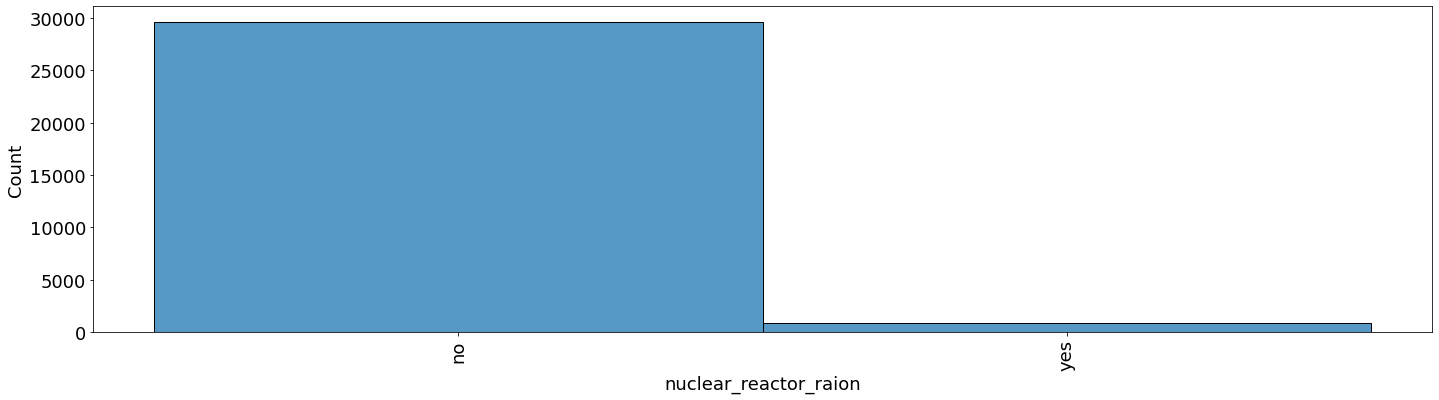

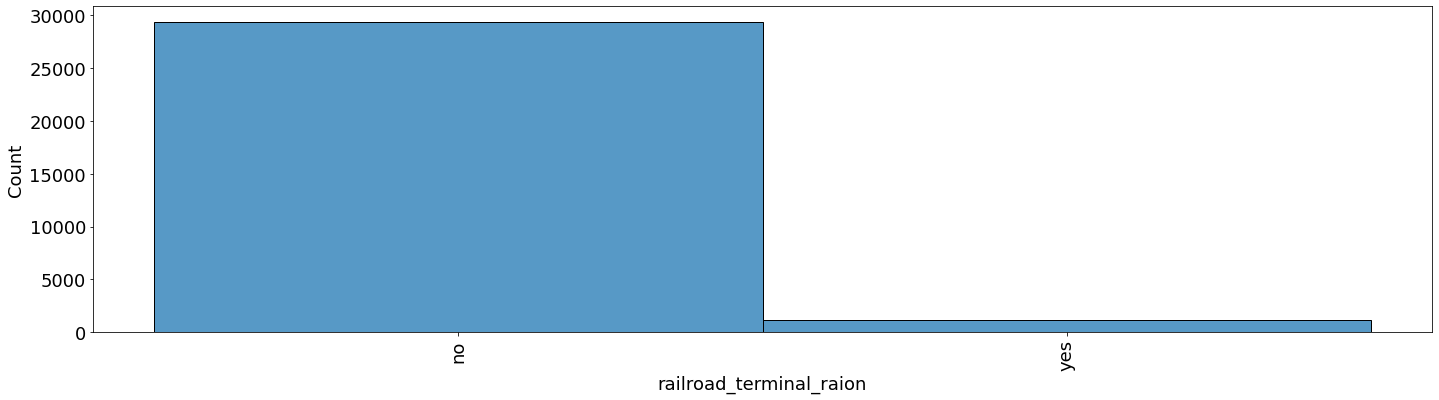

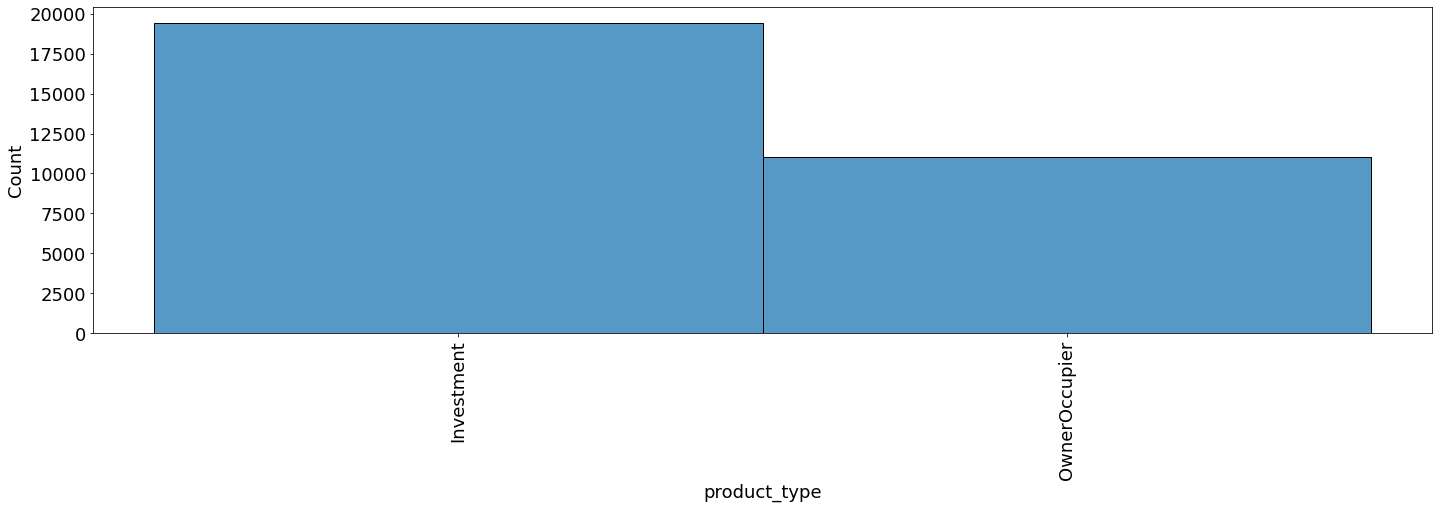

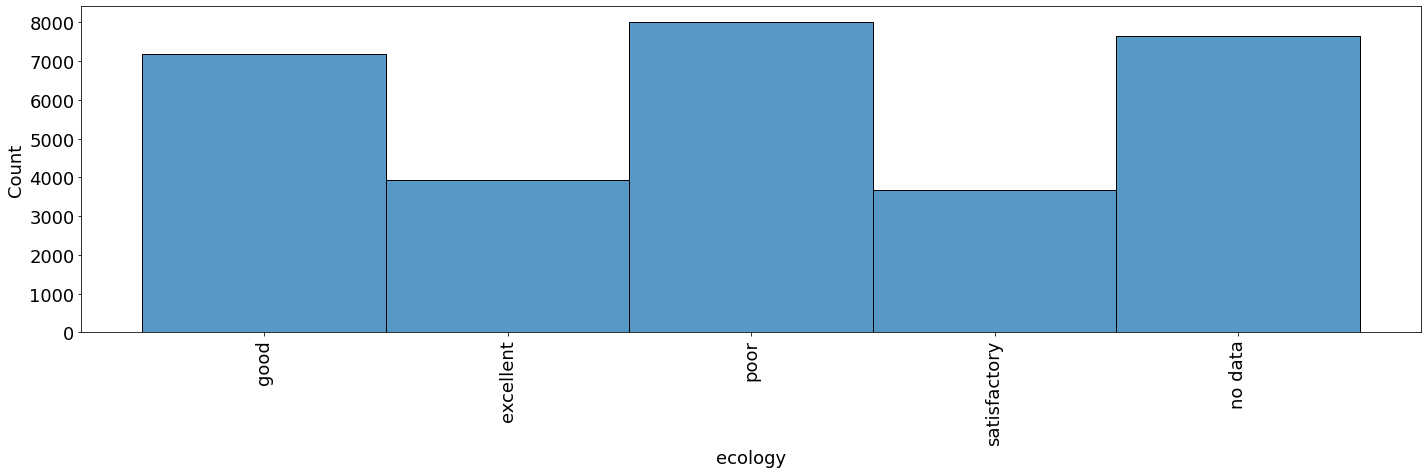

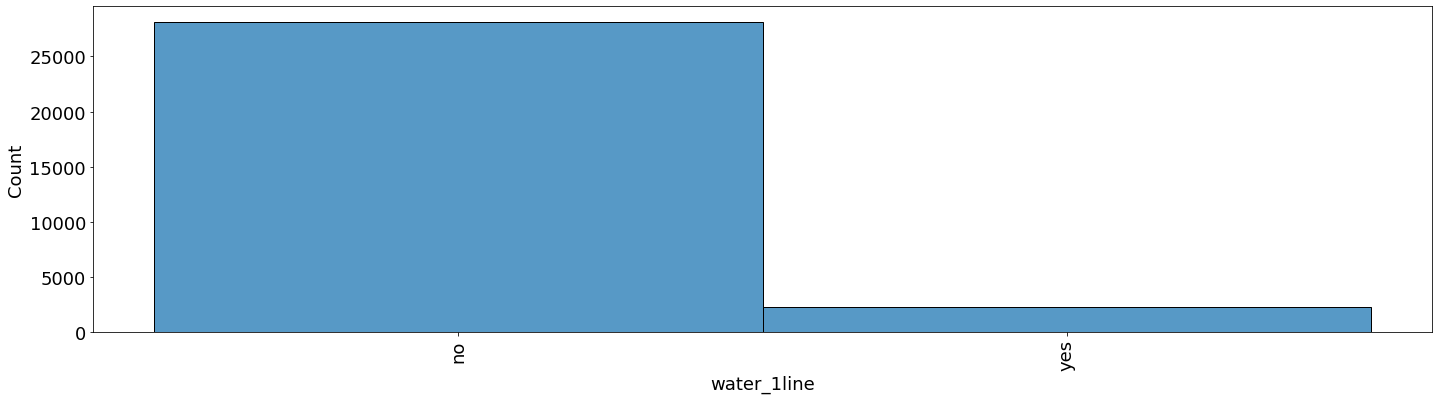

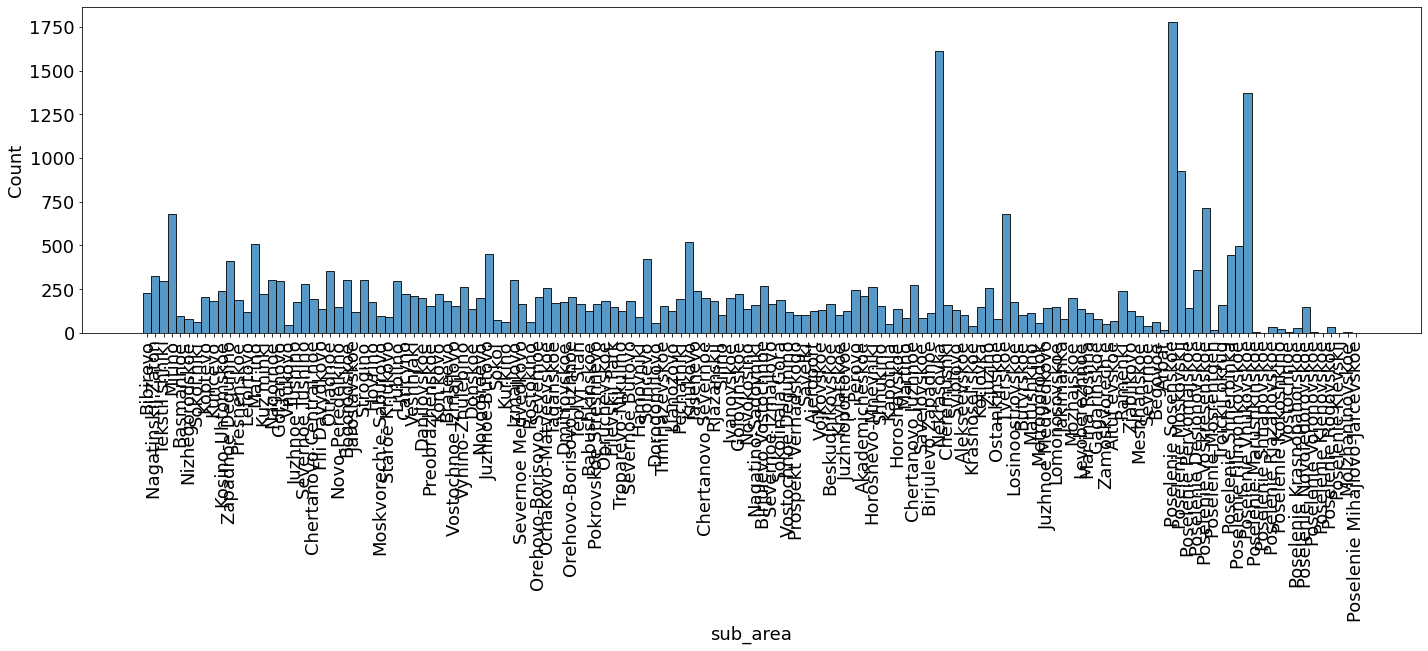

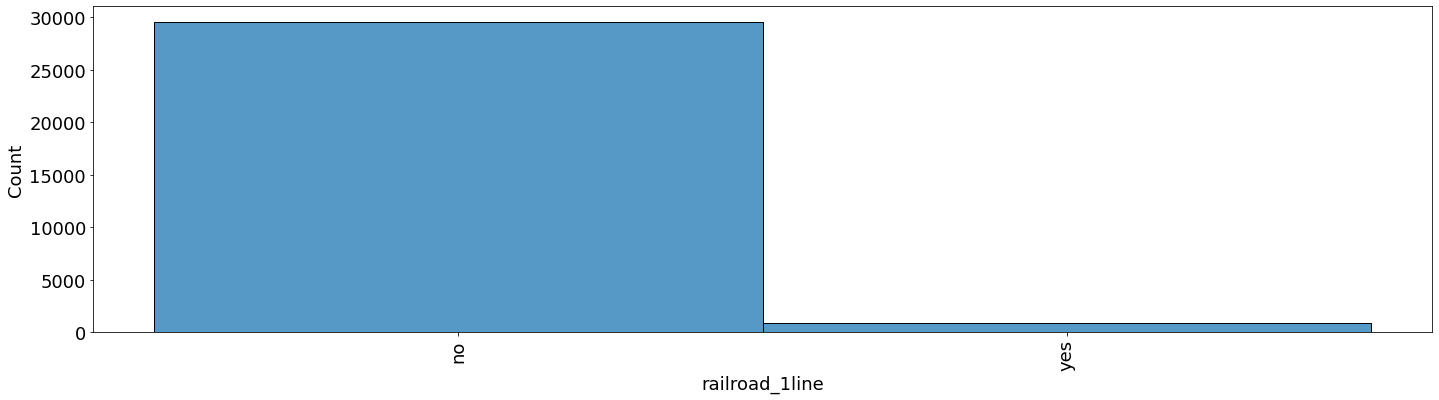

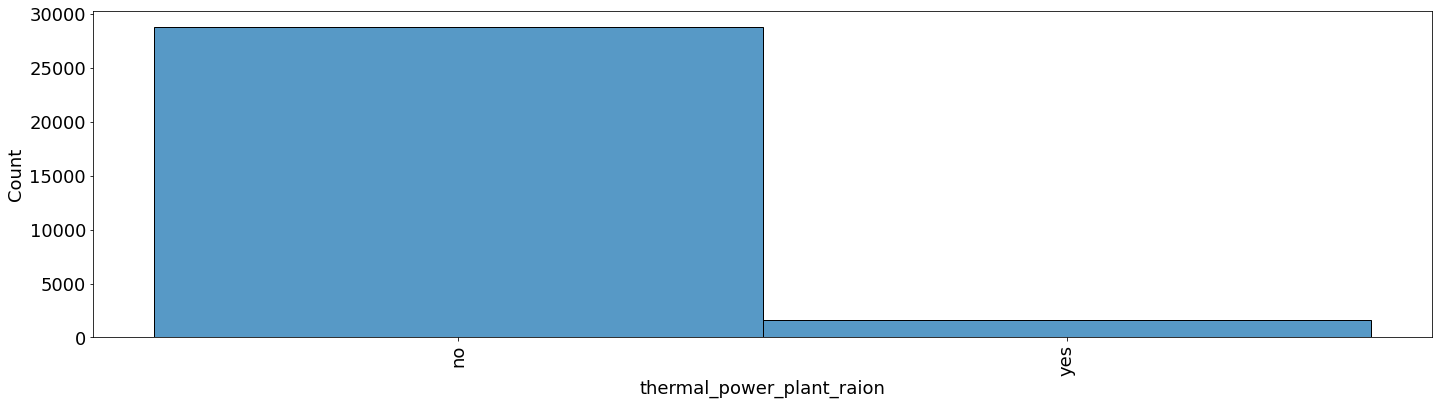

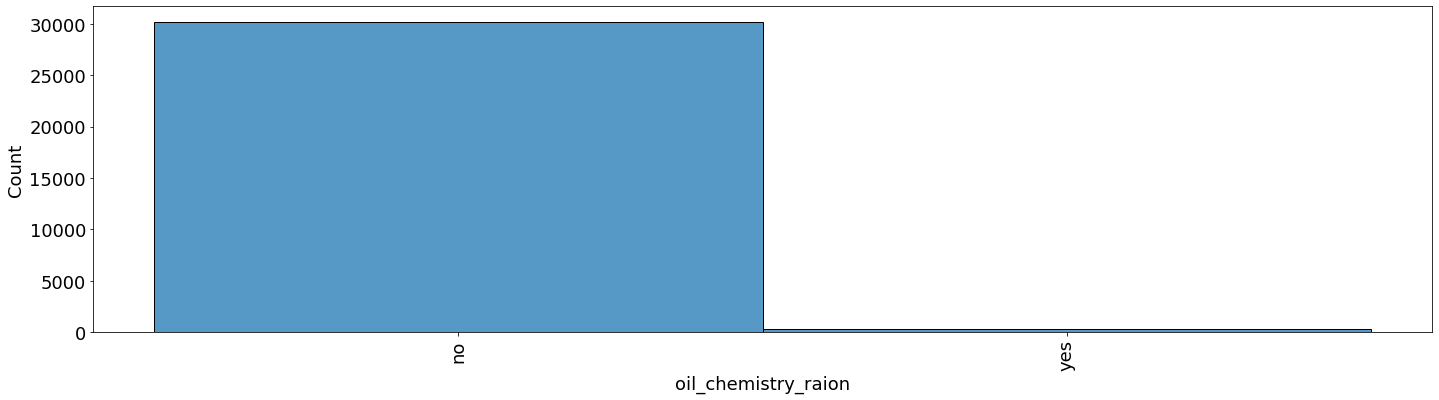

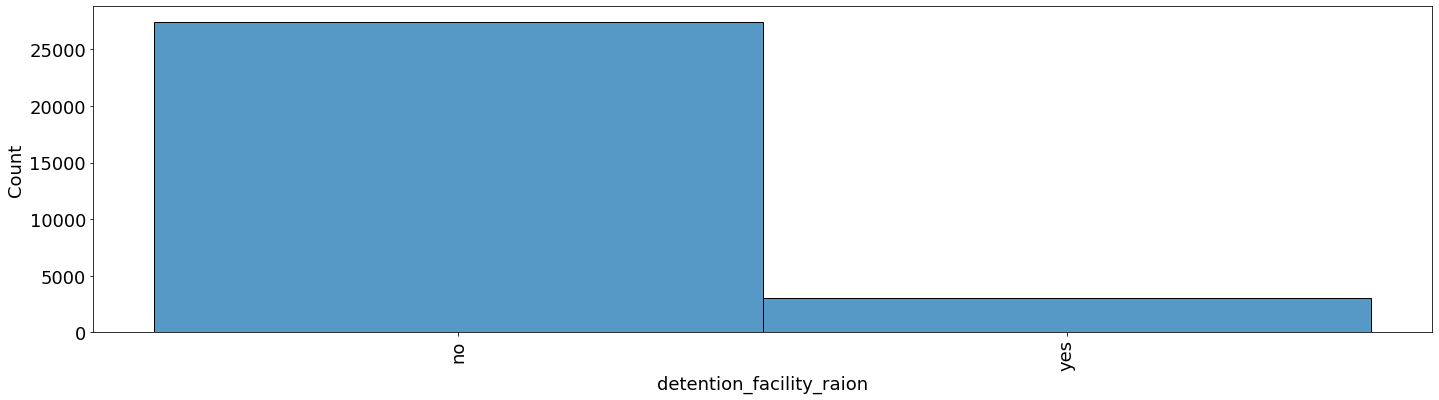

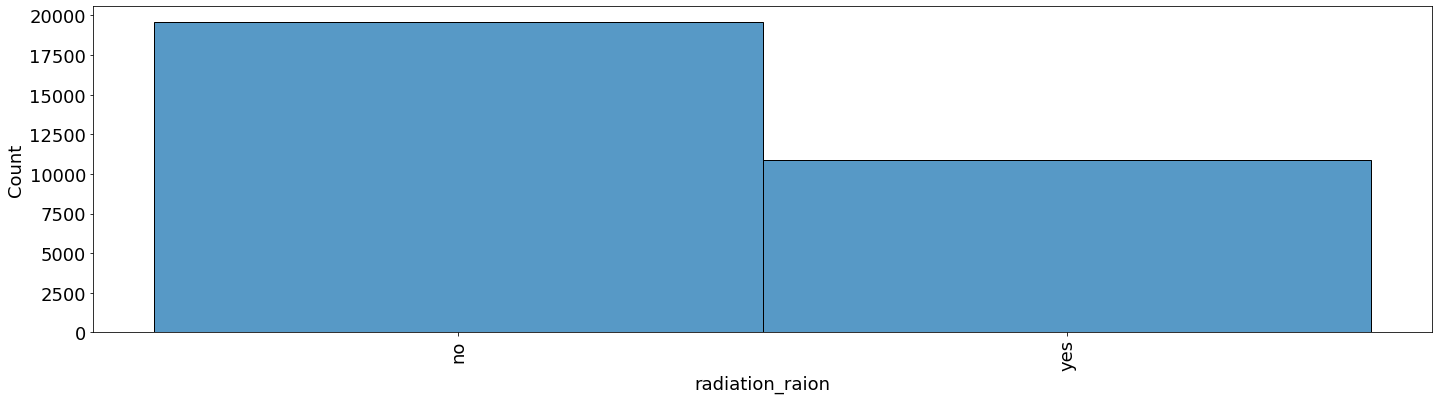

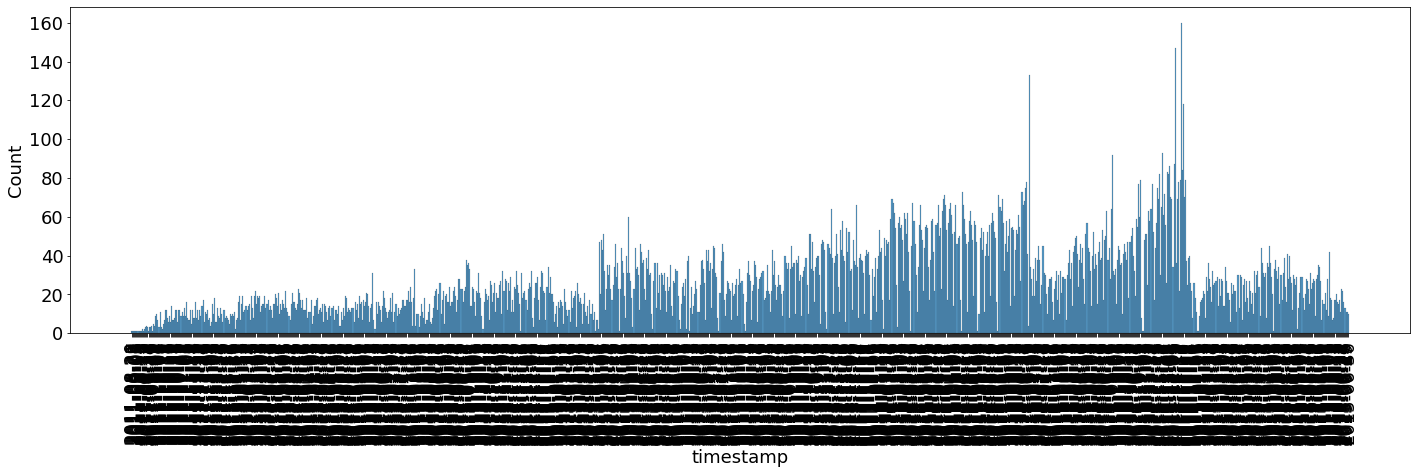

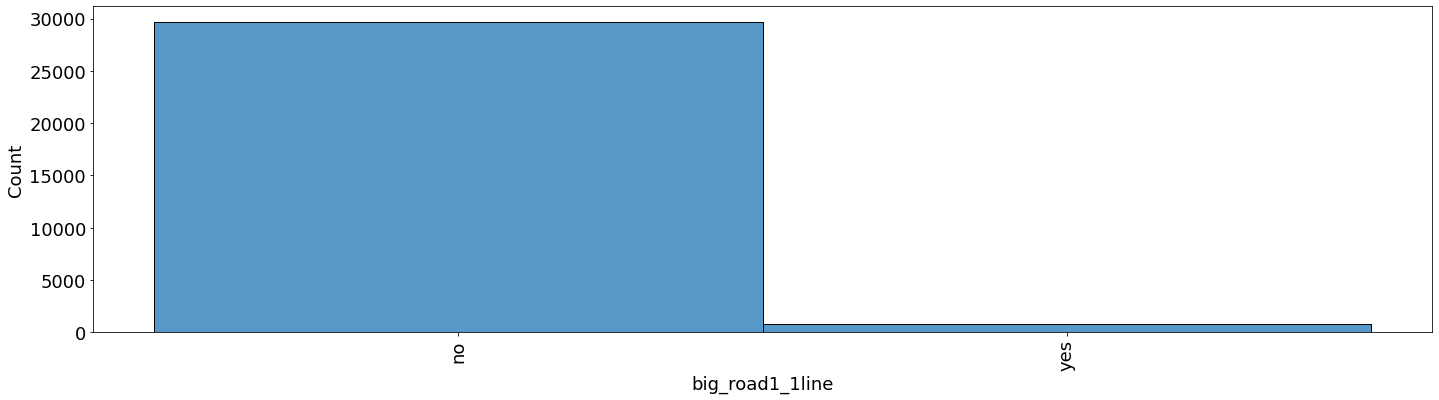

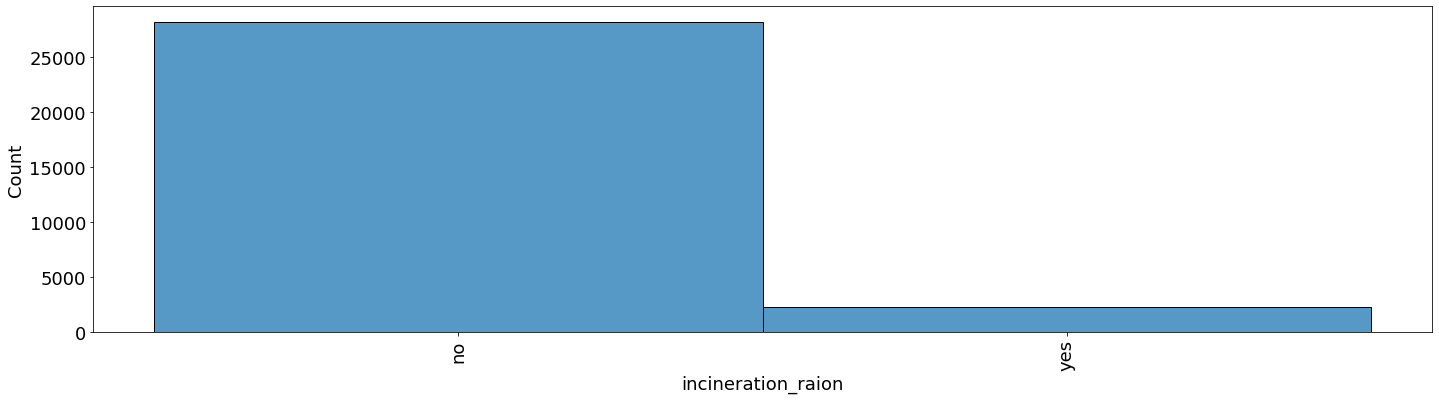

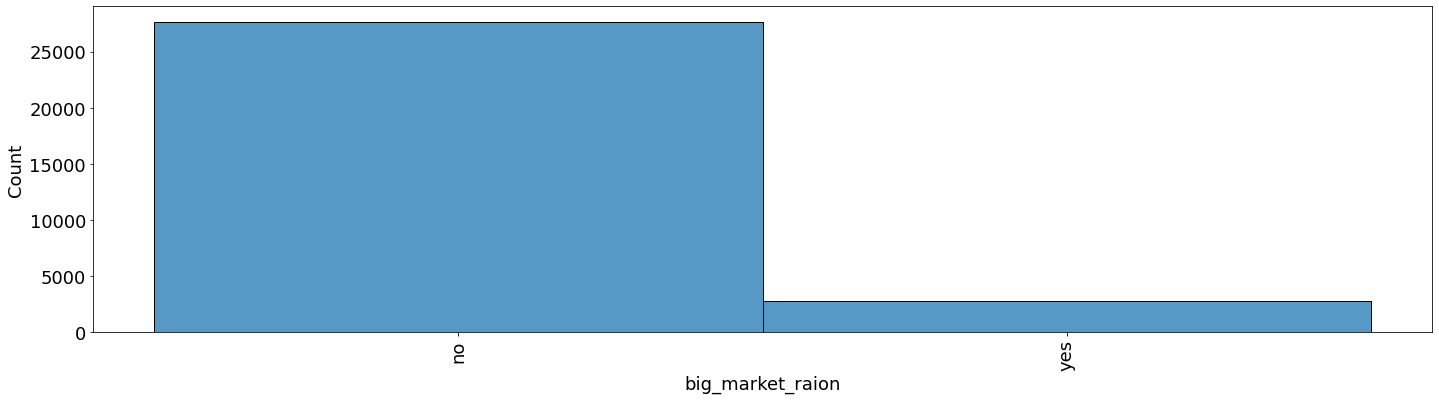

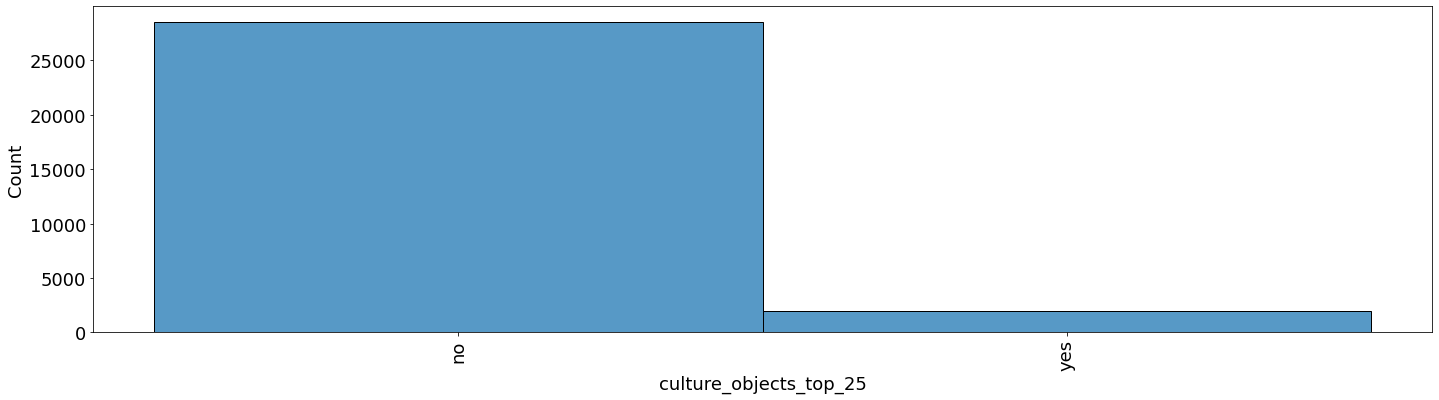

In [ ]:
for col in categorical_cols:
    plt.figure(figsize=(24, 6))
    sns.histplot(data=df[categorical_cols], x=col)
    plt.xticks(rotation=90)
    plt.show()

Как видно из полученных гистограмм, для многих бинарных признаков характерна ситуация, когда одно из двух значений признака встречается сильно реже, чем другое. Удалим такие признаки.

In [ ]:
binary_cols = [col for col in categorical_cols if df[col].nunique() == 2 and col != "product_type"]
# "product_type" принимает значения, отличные от 'no'/'yes' и соотношение категорий приемлимое, поэтому мы сразу не будем включать сюда данный признак
categorical_cols = [col for col in categorical_cols if col not in binary_cols]
len(binary_cols), len(categorical_cols)

(12, 4)

In [ ]:
min_p_yes = 0.2
for col in binary_cols:
    fr = df[col].value_counts().to_dict()
    print(col, fr)
    if fr["yes"] / fr["no"] < min_p_yes * fr["no"]:
        cols_to_delete.append(col)
len(cols_to_delete)

nuclear_reactor_raion {'no': 29608, 'yes': 863}
railroad_terminal_raion {'no': 29335, 'yes': 1136}
water_1line {'no': 28134, 'yes': 2337}
railroad_1line {'no': 29578, 'yes': 893}
thermal_power_plant_raion {'no': 28817, 'yes': 1654}
oil_chemistry_raion {'no': 30175, 'yes': 296}
detention_facility_raion {'no': 27427, 'yes': 3044}
radiation_raion {'no': 19600, 'yes': 10871}
big_road1_1line {'no': 29690, 'yes': 781}
incineration_raion {'no': 28155, 'yes': 2316}
big_market_raion {'no': 27649, 'yes': 2822}
culture_objects_top_25 {'no': 28543, 'yes': 1928}


29

In [ ]:
len(set(binary_cols) & set(cols_to_delete)) == len(binary_cols)

True

Т. е. все бинарные колонки удалили. Поделим выборку на обучающую и тестовую таким образом, чтобы до определенной даты информация о квартирах попала в обучающую выборку, а после — в тестовую:

In [ ]:
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d")

# Проверим, что они отсортированы по возрастанию даты
(df["timestamp"] == sorted(df["timestamp"])).sum() == df.shape[0]

True

Т. е. исходная выборка уже отсортирована в порядке возрастания дат. Пусть первые 70 % данных будут обучающей выборкой, а остальные данные — тестовой выборкой (только нужно учитывать, что даты могут повторяться для нескольких объектов). Колонку с датами использовать не будем.

In [ ]:
last_date = df["timestamp"][:int(df.shape[0] * 0.7)].iloc[-1]
cols_to_delete.append("timestamp")
categorical_cols.remove("timestamp")

In [ ]:
train_idx = df["timestamp"] <= last_date
train_idx

0         True
1         True
2         True
3         True
4         True
         ...  
30466    False
30467    False
30468    False
30469    False
30470    False
Name: timestamp, Length: 30471, dtype: bool

In [ ]:
X_train = df[train_idx]
y_train = target[train_idx]

X_test = df[~train_idx]
y_test = target[~train_idx]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((21332, 291), (21332,), (9139, 291), (9139,))

Удалим колонки, которые собирались удалить, и закодируем категориальные признаки. Нормализовывать численные признаки не будем, потому что далее будут использоваться модели, в основе которых лежит решающее дерево.

In [ ]:
X_train = X_train.drop(cols_to_delete, axis=1)
X_test = X_test.drop(cols_to_delete, axis=1)

In [ ]:
o_enc = OrdinalEncoder()

X_train[categorical_cols] = pd.DataFrame(
    o_enc.fit_transform(X_train[categorical_cols]),
    columns=categorical_cols
)
X_test[categorical_cols] = pd.DataFrame(
    o_enc.transform(X_test[categorical_cols]),
    columns=categorical_cols
)

Проверим, что в наших выборках нет пропущенных значений:

In [ ]:
nan_cols_train = (X_train.isna().sum().index[X_train.isna().sum() > 0]).tolist()
nan_cols_test = (X_test.isna().sum().index[X_test.isna().sum() > 0]).tolist()
len(nan_cols_train), len(nan_cols_test), len(set(nan_cols_train) & set(nan_cols_test))

(35, 37, 34)

In [ ]:
set(nan_cols_train) & set(categorical_cols), set(nan_cols_test) & set(categorical_cols)

(set(), {'ecology', 'product_type', 'sub_area'})

Проверим, что пропусков не осталось.

In [ ]:
nan_cols_train = (X_train.isna().sum().index[X_train.isna().sum() > 0]).tolist()
nan_cols_test = (X_test.isna().sum().index[X_test.isna().sum() > 0]).tolist()
len(nan_cols_train), len(nan_cols_test)

(35, 37)

В обучающей выборке пропущенные значения содержатся только в численных признаках, их будем заполнять средним значением из обучающей выборки (и для обучающей, и для тестовой выборки). А пропуски в категориальных признаках из тестовой выборки заполним наиболее часто встречающимися значениями из обучающей выборки.

In [ ]:
for col in nan_cols_train:
    X_train[col] = X_train[col].fillna(np.nanmean(X_train[col]))
    X_test[col] = X_test[col].fillna(np.nanmean(X_train[col]))

In [ ]:
for col in set(nan_cols_test) & set(categorical_cols):
    fill_with = X_train[col].value_counts().index[0]
    X_test[col] = X_test[col].fillna(fill_with)

Данных много, подбор гиперпараметров проводить не будем, но вы можете проделать это в качестве упражнения.

In [ ]:
CONFIG_DATA = {
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
}
CONFIG_REG = {
    "scoring": "r2", # подбирать гиперпараметры будем по R2
    "model_type": "regression",
}

In [ ]:
ans_cl = dict()
print("Результаты моделей с гиперпараметрами по умолчанию\n")
for model_name, model in tqdm(
        zip(
            ["RandomForest", "XGBoost", "LightGBM", "CatBoost"],
            [RandomForestRegressor(), XGBRegressor(), LGBMRegressor(), CatBoostRegressor(verbose=0)]
        )
):
    print(model_name)
    preds, metrics = model_train_test(model=model, model_type="regression", **CONFIG_DATA)
    ans_cl[model_name] = (preds, metrics)
    print("-"*100)

Результаты моделей с гиперпараметрами по умолчанию



0it [00:00, ?it/s]

RandomForest


1it [06:03, 363.03s/it]

MSE = 9444863890510.348; MAE = 1869229.674; R2 = 0.659
----------------------------------------------------------------------------------------------------
XGBoost
[14:06:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


2it [06:20, 159.49s/it]

MSE = 9012069284456.127; MAE = 1873974.337; R2 = 0.674
----------------------------------------------------------------------------------------------------
LightGBM


3it [06:27, 90.08s/it] 

MSE = 8679142746560.804; MAE = 1795975.723; R2 = 0.686
----------------------------------------------------------------------------------------------------
CatBoost


4it [07:23, 110.91s/it]

MSE = 8394659973743.697; MAE = 1789780.508; R2 = 0.697
----------------------------------------------------------------------------------------------------


In [ ]:
ans_cl_df = pd.DataFrame(ans_cl).T
ans_cl_df["MSE"] = ans_cl_df[1].apply(lambda x: x[0])
ans_cl_df["MAE"] = ans_cl_df[1].apply(lambda x: x[1])
ans_cl_df["R2"] = ans_cl_df[1].apply(lambda x: x[2])
ans_cl_df = ans_cl_df.drop([0, 1], axis=1)

# Отсортируем получившуюся таблицу по убыванию R2
ans_cl_df.sort_values("R2", ascending=False)

,MSE,MAE,R2
CatBoost,8.394660e+12,1.789781e+06,0.696709
LightGBM,8.679143e+12,1.795976e+06,0.686431
XGBoost,9.012069e+12,1.873974e+06,0.674402
RandomForest,9.444864e+12,1.869230e+06,0.658766


При сравнении гиперпараметров по умолчанию наилучшим алгоритмом оказался CatBoost, хотя все модели показали примерно одинаковый результат (конечно, не сильно высокий, но вполне приемлемый).

Таким образом, при выборе алгоритма необходимо опираться на постановку конкретной задачи, поскольку каждый алгоритм имеет свои особенности (учитывая также время обучения и тестирования модели). Однако сильной разницы между ними нет.